# Creación de Transformer para clasificar noticias

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Junio 2025

**Versión:** 1.0  



---

## Descripción


Este notebook implementa una versión simplificada de un codificador Transformer para clasificación de noticias.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

-

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

In [ ]:
# Solo si es necesario
!pip install -q tensorflow

In [64]:
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/news_pairs_dataset.csv

--2025-06-08 23:01:43--  https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/news_pairs_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28879 (28K) [text/plain]
Saving to: ‘news_pairs_dataset.csv’

news_pairs_dataset. 100%[===================>]  28.20K  --.-KB/s    in 0.003s  

2025-06-08 23:01:43 (8.92 MB/s) - ‘news_pairs_dataset.csv’ saved [28879/28879]



In [21]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Cargar dataset
data = pd.read_csv("news_pairs_dataset.csv")
texts = data["input"].values
labels = data["target"].values

# Codificar etiquetas
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(texts, labels_encoded, test_size=0.2, random_state=29)

In [19]:
data.head()

,input,target
0,Cryptocurrency values surged overnight.,Business
1,Fans gathered to celebrate the unexpected vict...,Sports
2,A merger between two large firms was finalized.,Business
3,A controversial referee decision changed the o...,Sports
4,Investors are cautious due to inflation concerns.,Business


In [39]:
data.shape

(500, 2)

In [20]:
data.target.unique()

array(['Business', 'Sports', 'Sci/Tech', 'World'], dtype=object)

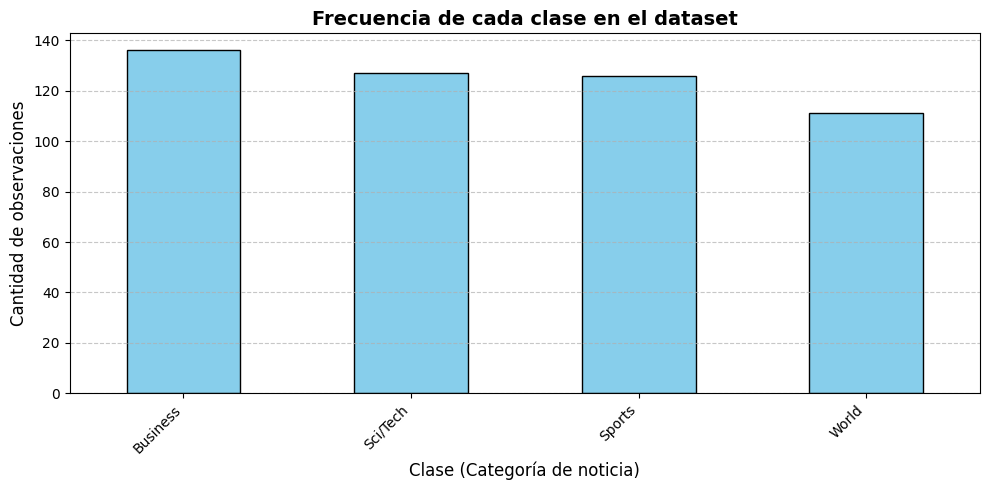

In [22]:
# Calcular frecuencia de clases
label_counts = pd.Series(labels).value_counts()

# Graficar
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Frecuencia de cada clase en el dataset", fontsize=14, fontweight="bold")
plt.xlabel("Clase (Categoría de noticia)", fontsize=12)
plt.ylabel("Cantidad de observaciones", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [16]:
# Vectorización de texto
MAX_LEN = 40
VOCAB_SIZE = 8192

vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LEN)
vectorizer.adapt(X_train)

# Dataset final
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorizer(text), label

# Obtiene el set de datos de entrenamiento
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(lambda x, y: (vectorizer(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)

# Obtiene el set de datos de test
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(lambda x, y: (vectorizer(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)


In [40]:

# Encoder
def crear_encoder(vocab_size, d_model, num_heads, ff_dim):
    inputs = tf.keras.layers.Input(shape=(None,))
    x = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = tf.keras.layers.Normalization()(x + tf.keras.layers.Dropout(0.1)(attn))
    ffn = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + tf.keras.layers.Dense(d_model)(ffn))
    return tf.keras.models.Model(inputs, x, name="Encoder")

# Decoder
def crear_decoder(d_model, num_classes):
    inputs = tf.keras.layers.Input(shape=(None, d_model))
    x = tf.keras.layers.GlobalAveragePooling1D()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(inputs, outputs, name="Decoder")

# Transformer Classifier
def build_transformer_classifier(vocab_size, d_model, num_heads, ff_dim, num_classes, x_name="Mi_Transformer"):
    encoder = crear_encoder(vocab_size, d_model, num_heads, ff_dim)
    decoder = crear_decoder(d_model, num_classes)
    inputs = tf.keras.layers.Input(shape=(None,), name="CapaEntrada")
    encoded = encoder(inputs)
    outputs = decoder(encoded)
    return tf.keras.models.Model(inputs, outputs, name=x_name)

# Modelo 1

In [53]:
# Compilar modelo
modelo = build_transformer_classifier(VOCAB_SIZE, 64, 4, 128, num_classes)
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar
history = modelo.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.2493 - loss: 1.5349 - val_accuracy: 0.2800 - val_loss: 1.2747
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4826 - loss: 1.1807 - val_accuracy: 0.5700 - val_loss: 1.0089
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7136 - loss: 0.9225 - val_accuracy: 0.9300 - val_loss: 0.7573
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9776 - loss: 0.6654 - val_accuracy: 1.0000 - val_loss: 0.5457
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.4472 - val_accuracy: 1.0000 - val_loss: 0.2906


In [54]:
print(modelo.summary())

Model: "Mi_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CapaEntrada (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, None, 64)       │       607,489 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 4)              │         4,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,835,471 (7.00 MB)

 Trainable params: 611,780 (2.33 MB)

 Non-trainable params: 129 (520.00 B)

 Optimizer params: 1,223,562 (4.67 MB)

None


In [55]:
# Evaluar
modelo.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.2940


[0.2906392514705658, 1.0]

# Modelo 2

In [56]:
# Compilar modelo
modelo_x = build_transformer_classifier(VOCAB_SIZE, 64, 8, 128,
                                        num_classes, x_name="Transformer_con_8_cabezales")
modelo_x.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar
history_x = modelo.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.2186 - val_accuracy: 1.0000 - val_loss: 0.0683
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0508 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0013


In [57]:
print(modelo_x.summary())

Model: "Transformer_con_8_cabezales"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CapaEntrada (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, None, 64)       │       673,793 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 4)              │         4,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,213 (2.59 MB)

 Trainable params: 678,084 (2.59 MB)

 Non-trainable params: 129 (520.00 B)

None


In [58]:
# Evaluar
modelo_x.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3056 - loss: 1.4099


[1.426729679107666, 0.28999999165534973]

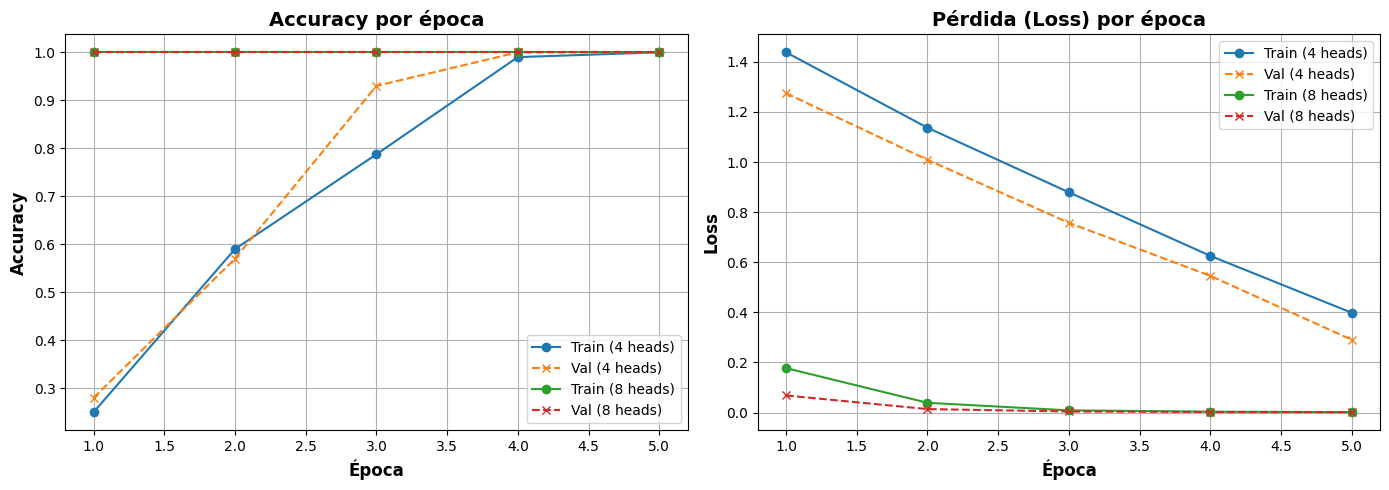

In [62]:
# Extraer métricas
acc_4 = history.history["accuracy"]
val_acc_4 = history.history["val_accuracy"]
loss_4 = history.history["loss"]
val_loss_4 = history.history["val_loss"]

acc_8 = history_x.history["accuracy"]
val_acc_8 = history_x.history["val_accuracy"]
loss_8 = history_x.history["loss"]
val_loss_8 = history_x.history["val_loss"]

epochs = range(1, len(acc_4) + 1)

# Crear figura
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_4, label="Train (4 heads)", marker='o')
plt.plot(epochs, val_acc_4, label="Val (4 heads)", linestyle='--', marker='x')
plt.plot(epochs, acc_8, label="Train (8 heads)", marker='o')
plt.plot(epochs, val_acc_8, label="Val (8 heads)", linestyle='--', marker='x')
plt.title("Accuracy por época", fontsize=14, fontweight="bold")
plt.xlabel("Época", fontsize=12, fontweight="bold")
plt.ylabel("Accuracy", fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_4, label="Train (4 heads)", marker='o')
plt.plot(epochs, val_loss_4, label="Val (4 heads)", linestyle='--', marker='x')
plt.plot(epochs, loss_8, label="Train (8 heads)", marker='o')
plt.plot(epochs, val_loss_8, label="Val (8 heads)", linestyle='--', marker='x')
plt.title("Pérdida (Loss) por época", fontsize=14, fontweight="bold")
plt.xlabel("Época", fontsize=12, fontweight="bold")
plt.ylabel("Loss", fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Predicciones

In [59]:
# Predicción nueva
def predecir_noticia(texto, modelo):
  # Vectoriza el texto
  vector = vectorizer([texto])
  # Realiza la predicción
  pred = modelo.predict(vector)
  # Obtiene la clase predicha
  idx = tf.argmax(pred[0]).numpy()
  # Retorna la etiqueta de la predicción
  return label_encoder.inverse_transform([idx])[0], pred[0][idx]

In [60]:
# Ejemplos
news = ["The president met with the prime minister to discuss economic policies.",
        "The team win the competition in the great final"]
for new in news:
  tipo, probabilidad = predecir_noticia(new, modelo)
  tipo_x, probabilidad_x = predecir_noticia(new, modelo_x)
  print(f"Noticia: {new}")
  print(f"Tipo (modelo 1): {tipo}")
  print(f"Probabilidad (modelo 1): {probabilidad}")
  print(f"Tipo (modelo 2): {tipo_x}")
  print(f"Probabilidad (modelo 2): {probabilidad_x}")
  print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Noticia: The president met with the prime minister to discuss economic policies.
Tipo (modelo 1): Sports
Probabilidad (modelo 1): 0.8712661266326904
Tipo (modelo 2): Sports
Probabilidad (modelo 2): 0.430144339799881

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Noticia: The team win the competition in the great final
Tipo (modelo 1): Sports
Probabilidad (modelo 1): 0.9962571859359741
Tipo (modelo 2): Sports
Probabilidad (modelo 2): 0.4434417188167572

